<a href="https://colab.research.google.com/github/Diajeng17/Klasifikasi_Gelas_Diajeng/blob/main/KLASIFIKASI_GELAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Import Necessary Libraries

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import cv2

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_dir = '/content/drive/MyDrive/gelas_dataset'

In [4]:
import os

print("Folder tersedia:", os.path.exists(data_dir))
print("Isi folder:", os.listdir(data_dir))


Folder tersedia: True
Isi folder: ['test', 'train', 'val']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
print(f"Jumlah data train: {len(train_dataset)}")
print(f"Kelas: {train_dataset.classes}")


Jumlah data train: 596
Kelas: ['gelas_kaca ', 'gelas_keramik ', 'gelas_kertas ', 'gelas_plastik ']


In [ ]:
Load and Transform Data

In [8]:
data_dir = "/content/drive/MyDrive/gelas_dataset"
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

In [12]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

In [13]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [14]:
print(f"Jumlah data train: {len(train_data)}")
print(f"Jumlah data validasi: {len(val_data)}")
print(f"Jumlah data test: {len(test_data)}")
print(f"Daftar kelas: {train_data.classes}")

Jumlah data train: 596
Jumlah data validasi: 192
Jumlah data test: 240
Daftar kelas: ['gelas_kaca ', 'gelas_keramik ', 'gelas_kertas ', 'gelas_plastik ']


In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
Visualizing Images from the Dataset

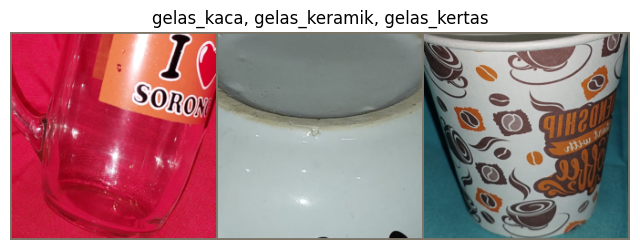

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Ambil satu batch gambar
inputs, labels = next(iter(train_loader))
class_names = ['gelas_kaca', 'gelas_keramik', 'gelas_kertas', 'gelas_plastik']

# Simpan satu gambar per kelas unik
seen_classes = set()
selected_imgs = []
selected_labels = []

for img, lbl in zip(inputs, labels):
    if lbl.item() not in seen_classes:
        seen_classes.add(lbl.item())
        selected_imgs.append(img)
        selected_labels.append(lbl.item())
    if len(seen_classes) == 4:
        break

# Buat grid dan tampilkan
out = torchvision.utils.make_grid(selected_imgs)
imshow(out, title=", ".join([class_names[i] for i in selected_labels]))

In [ ]:
Computing Error Rate Analysis (as a function)

In [17]:
def compute_error_rate(preds, labels):
    return 1 - (preds == labels).sum().item() / len(labels)

In [18]:
# Data Preprocessing (already included in transforms)

In [ ]:
# Training the Model

In [19]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze feature extractor

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_data.classes))  # Custom output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


Epoch 1/50 | Train Loss: 0.9414 | Val Loss: 1.4227
Epoch 2/50 | Train Loss: 0.4900 | Val Loss: 0.8550
Epoch 3/50 | Train Loss: 0.3633 | Val Loss: 0.7629
Epoch 4/50 | Train Loss: 0.2873 | Val Loss: 0.7062
Epoch 5/50 | Train Loss: 0.2451 | Val Loss: 0.6355
Epoch 6/50 | Train Loss: 0.2205 | Val Loss: 0.6149
Epoch 7/50 | Train Loss: 0.1673 | Val Loss: 0.5653
Epoch 8/50 | Train Loss: 0.1586 | Val Loss: 0.5241
Epoch 9/50 | Train Loss: 0.1532 | Val Loss: 0.5287
Epoch 10/50 | Train Loss: 0.1531 | Val Loss: 0.5060
Epoch 11/50 | Train Loss: 0.1335 | Val Loss: 0.5516
Epoch 12/50 | Train Loss: 0.1157 | Val Loss: 0.4716
Epoch 13/50 | Train Loss: 0.1168 | Val Loss: 0.5670
Epoch 14/50 | Train Loss: 0.1104 | Val Loss: 0.5177
Epoch 15/50 | Train Loss: 0.1037 | Val Loss: 0.5352
Epoch 16/50 | Train Loss: 0.1012 | Val Loss: 0.5503
Epoch 17/50 | Train Loss: 0.0931 | Val Loss: 0.4553
Epoch 18/50 | Train Loss: 0.0942 | Val Loss: 0.5461
Epoch 19/50 | Train Loss: 0.0944 | Val Loss: 0.5021
Epoch 20/50 | Train L

In [20]:
import torch
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=test_data.classes))

                precision    recall  f1-score   support

   gelas_kaca        0.97      1.00      0.98        60
gelas_keramik        0.68      1.00      0.81        60
 gelas_kertas        0.91      1.00      0.95        60
 gelas_plastik       1.00      0.40      0.57        60

      accuracy                           0.85       240
     macro avg       0.89      0.85      0.83       240
  weighted avg       0.89      0.85      0.83       240



In [ ]:
Model Evaluation

                precision    recall  f1-score   support

   gelas_kaca        0.97      1.00      0.98        60
gelas_keramik        0.68      1.00      0.81        60
 gelas_kertas        0.91      1.00      0.95        60
 gelas_plastik       1.00      0.40      0.57        60

      accuracy                           0.85       240
     macro avg       0.89      0.85      0.83       240
  weighted avg       0.89      0.85      0.83       240



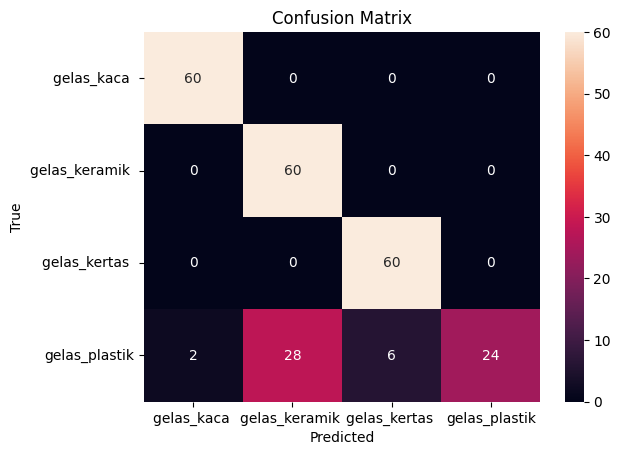

In [34]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
Visualizing Loss Curves

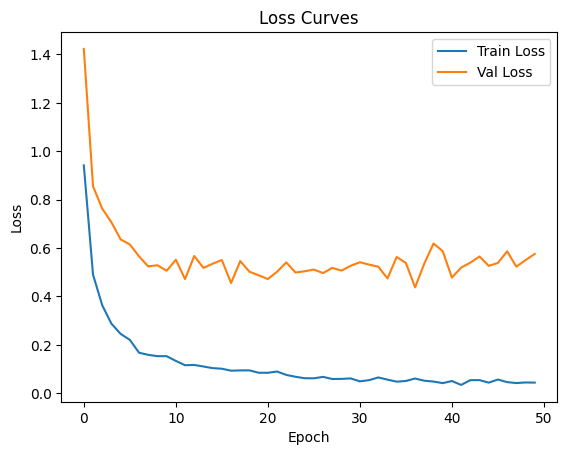

In [25]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

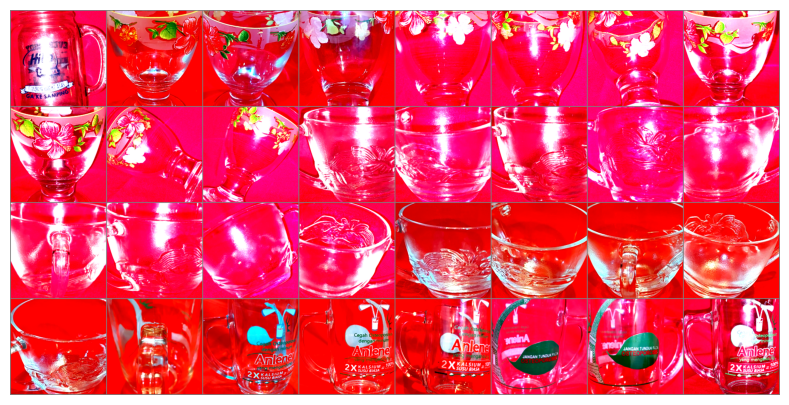

Predicted: ['gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ', 'gelas_kaca ']


In [31]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Pastikan model dan device sudah didefinisikan
model.eval()

# Ambil satu batch dari test_loader
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device)

# Prediksi tanpa mengaktifkan gradient
with torch.no_grad():
    outputs = model(sample_images)
    _, preds = torch.max(outputs, 1)

# Tampilkan gambar-gambar dan prediksinya
def imshow(img):
    img = img / 2 + 0.5  # unnormalize jika datanya dinormalisasi
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Tampilkan gambar dan hasil prediksi
imshow(make_grid(sample_images.cpu()))
print("Predicted:", [class_names[pred] for pred in preds.cpu()])

In [ ]:
Making Predictions on Test Data

In [33]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return class_names[pred.item()]

In [ ]:
Grad-Cam Visualization

Classes: ['test', 'train', 'val']


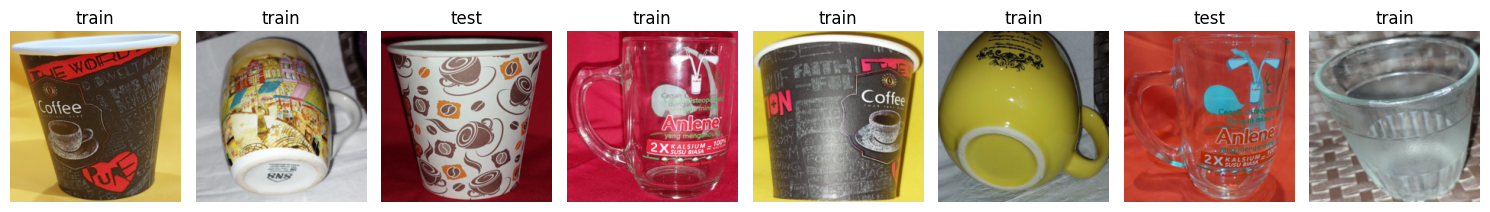

In [38]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Direktori dataset (pastikan lokasi direktori sesuai)
# dataset_dir = "path/to/gelas_dataset"  # Ganti dengan lokasi dataset Anda
dataset_dir = "/content/drive/MyDrive/gelas_dataset" # Replace with the actual path to your dataset

# Definisikan transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ubah ukuran gambar sesuai kebutuhan model
    transforms.ToTensor()           # Konversi gambar ke tensor
])

# Muat dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Ambil nama kelas dari dataset
class_names = dataset.classes
print("Classes:", class_names)  # Misalnya: ['gelas_kaca', 'gelas_keramik', 'gelas_kertas', 'gelas_plastik']

# Buat DataLoader untuk mengakses data
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Fungsi untuk menampilkan gambar
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  # Konversi format tensor ke format gambar (HWC)
        axes[i].imshow(image)
        axes[i].set_title(f"{class_names[label]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Ambil satu batch gambar dari DataLoader
images, labels = next(iter(data_loader))

# Tampilkan gambar dengan labelnya
show_images(images, labels)